Task - 1:

In [ ]:
import os
import numpy as np
from PIL import Image, UnidentifiedImageError
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report


train_dir = "/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/train"
corrupted_images = []

for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = Image.open(img_path)
                img.verify()
            except (IOError, SyntaxError, UnidentifiedImageError):
                corrupted_images.append(img_path)
                os.remove(img_path)
                print(f"Removed corrupted image: {img_path}")
if not corrupted_images:
    print("No corrupted images found.")

img_height, img_width = 128, 128
batch_size = 16
validation_split = 0.2
seed = 123
AUTOTUNE = tf.data.AUTOTUNE

train_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)

val_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)

class_names = train_raw.class_names
num_classes = len(class_names)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

rescale = layers.Rescaling(1. / 255)

def prepare_dataset(dataset, augment=False):
    dataset = dataset.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)
    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return dataset.shuffle(100).prefetch(buffer_size=AUTOTUNE)

train_ds = prepare_dataset(train_raw, augment=True)
val_ds = prepare_dataset(val_raw)


base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks
)

test_loss, test_acc = model.evaluate(val_ds)
print(f"\n✅ Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")


model.save("final_model.h5")


model = tf.keras.models.load_model("best_model.h5")
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))


No corrupted images found.
Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.1925 - loss: 2.2387

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 798ms/step - accuracy: 0.1975 - loss: 2.2242 - val_accuracy: 0.1111 - val_loss: 2.1911
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.1587 - loss: 2.2812

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - accuracy: 0.1646 - loss: 2.2684 - val_accuracy: 0.2222 - val_loss: 1.9277
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.3793 - loss: 1.8482

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - accuracy: 0.3739 - loss: 1.8547 - val_accuracy: 0.2778 - val_loss: 1.7972
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.3733 - loss: 1.7051

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 452ms/step - accuracy: 0.3782 - loss: 1.7032 - val_accuracy: 0.3889 - val_loss: 1.6958
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.3783 - loss: 1.4401

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - accuracy: 0.3708 - loss: 1.4539 - val_accuracy: 0.4444 - val_loss: 1.6186
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.4517 - loss: 1.2417 - val_accuracy: 0.4444 - val_loss: 1.5597
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.5351 - loss: 1.1715 - val_accuracy: 0.4444 - val_loss: 1.5070
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7246 - loss: 1.0890

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 303ms/step - accuracy: 0.7196 - loss: 1.0890 - val_accuracy: 0.5000 - val_loss: 1.4606
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8084 - loss: 0.7925

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - accuracy: 0.7825 - loss: 0.8233 - val_accuracy: 0.5556 - val_loss: 1.4319
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - accuracy: 0.4563 - loss: 1.2884 - val_accuracy: 0.5556 - val_loss: 1.3806
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.6982 - loss: 0.8195 - val_accuracy: 0.5556 - val_loss: 1.3395
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7333 - loss: 0.8196

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step - accuracy: 0.7361 - loss: 0.8120 - val_accuracy: 0.6111 - val_loss: 1.2971
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.7495 - loss: 0.7656 - val_accuracy: 0.6111 - val_loss: 1.2704
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.7551 - loss: 0.7304 - val_accuracy: 0.6111 - val_loss: 1.2489
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.7950 - loss: 0.7259 - val_accuracy: 0.6111 - val_loss: 1.2342
Epoch 16/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8383 - loss: 0.6357

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step - accuracy: 0.8259 - loss: 0.6521 - val_accuracy: 0.6667 - val_loss: 1.2175
Epoch 17/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - accuracy: 0.8634 - loss: 0.6277 - val_accuracy: 0.6667 - val_loss: 1.2024
Epoch 18/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step - accuracy: 0.9014 - loss: 0.4396 - val_accuracy: 0.6667 - val_loss: 1.1837
Epoch 19/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.9376 - loss: 0.4713 - val_accuracy: 0.6667 - val_loss: 1.1546
Epoch 20/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.8703 - loss: 0.4478 - val_accuracy: 0.6667 - val_loss: 1.1330
Epoch 21/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.8926 - loss: 0.4899 - val_accuracy: 0.6667 - val_loss: 1.1191
Epoch 22/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.8953 - loss: 0.4608 - val_accuracy: 0.6667 - val_loss: 1.1103
Epoch 23/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.8924 - loss: 0.4580 - val_accuracy: 0.6667 - val_lo


✅ Test Accuracy: 0.67, Test Loss: 1.22


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

=== Classification Report ===
              precision    recall  f1-score   support

        acai       0.50      1.00      0.67         1
     cupuacu       1.00      1.00      1.00         2
    graviola       1.00      1.00      1.00         3
     guarana       1.00      0.40      0.57         5
     pupunha       0.40      0.50      0.44         4
      tucuma       0.50      0.67      0.57         3

    accuracy                           0.67        18
   macro avg       0.73      0.76      0.71        18
weighted avg       0.76      0.67      0.67        18



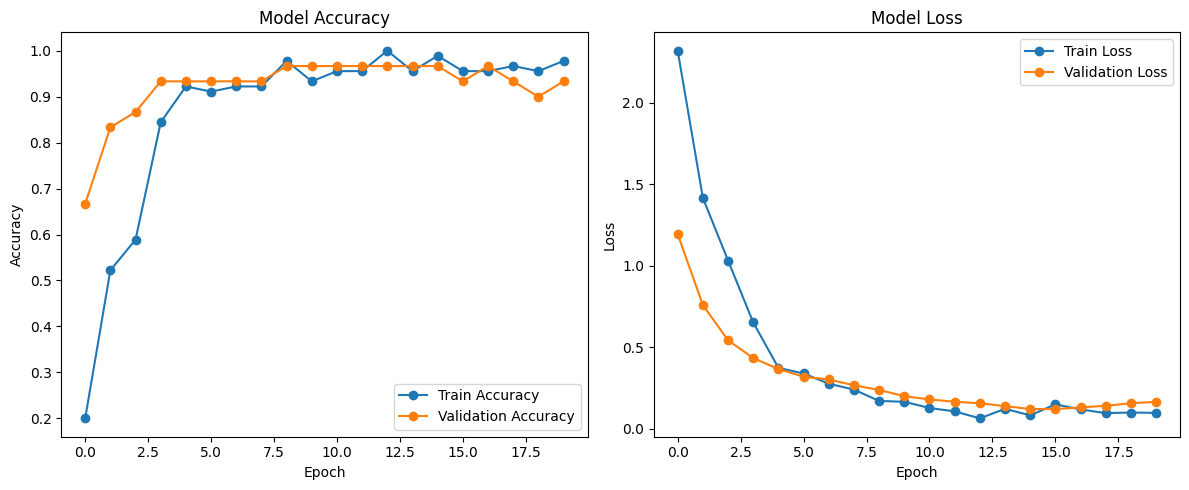

In [5]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


VGG16 Transfer Learning for Image Classification

In [ ]:
# Import necessary libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


train_dir = "/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/train"
val_dir = "/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/test"

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Scale pixel values to [0, 1]
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to match VGG16 input size
    batch_size=32,
    class_mode='categorical'  # Multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduces the spatial dimensions
x = Dense(1024, activation='relu')(x)  # Fully connected layer with 1024 neurons
x = Dense(6, activation='softmax')(x)  # Output layer for 6 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)


Found 90 images belonging to 6 classes.
Found 30 images belonging to 6 classes.
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 88s 32s/step - accuracy: 0.1386 - loss: 1.9196 - val_accuracy: 0.4333 - val_loss: 1.6973
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 30s/step - accuracy: 0.3168 - loss: 1.6732 - val_accuracy: 0.4333 - val_loss: 1.5879
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 76s 30s/step - accuracy: 0.5731 - loss: 1.4558 - val_accuracy: 0.4333 - val_loss: 1.5769
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 78s 29s/step - accuracy: 0.6622 - loss: 1.3132 - val_accuracy: 0.4667 - val_loss: 1.4444
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 76s 28s/step - accuracy: 0.7192 - loss: 1.1599 - val_accuracy: 0.6333 - val_loss: 1.3764
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 83s 28s/step - accuracy: 0.7528 - loss: 1.0688 - val_accuracy: 0.6000 - val_loss: 1.3765
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 76s 30s/step - accuracy: 0.7797 - loss: 1.0084 - val_accuracy: 0.4667 - val_loss: 1.3528
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 76s 28s/s

Task - 2:

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

 train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

 base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze layers

# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(
    train,
    validation_data=val,
    epochs=20
)

# Save model (Keras format)
model.save('my_model.keras')


Found 90 images belonging to 6 classes.
Found 30 images belonging to 6 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.1664 - loss: 2.4850 - val_accuracy: 0.6667 - val_loss: 1.1936
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.4760 - loss: 1.5116 - val_accuracy: 0.8333 - val_loss: 0.7591
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5874 - loss: 1.0516 - val_accuracy: 0.8667 - val_loss: 0.5434
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8310 - loss: 0.7121 - val_accuracy: 0.9333 - val_loss: 0.4341
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.9181 - loss: 0.3825 - val_accuracy: 0.9333 - val_loss: 0.3667
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9028 - loss: 0.3769 - val_accuracy: 0.9333 - val_loss: 0.3198
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9289 - loss: 0.2627 - val_accuracy: 0.9333 - val_loss: 0.3026
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.9181 - loss: 0.2504 - val_accuracy: 0.9333 - val_loss: 0.2671
Epoch 9/20
3/3

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


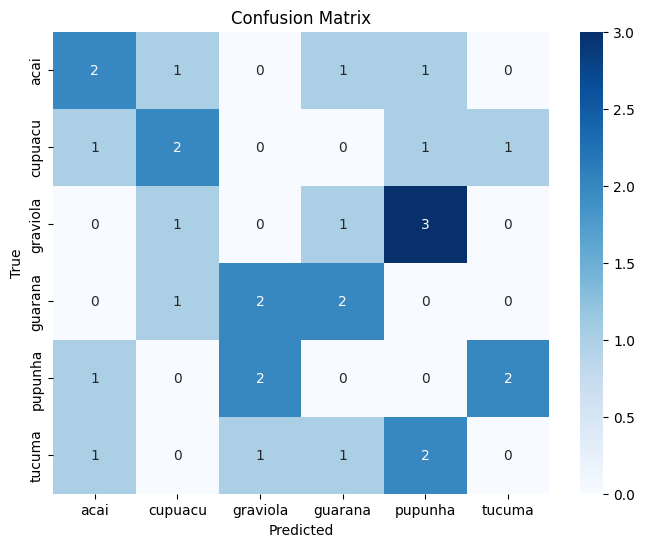

In [4]:
# Confusion Matrix
val.reset()
predictions = model.predict(val)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val.classes
class_labels = list(val.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
